## Years of Training

* How do outcome metrics relate to the years of training?

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
from pathlib import Path
from kedro.framework.context import load_context
sys.path.append("..")
from src.lifetime_dev.VPLifetimesData import VPLifetimesData
from src.lifetime_dev.VPLifetimesAnalysis import VPLifetimesAnalysis
from src.lifetime_dev.VPLifetimesOrderPredictAnalyze import VPLifetimesOrderPredictAnalyze
from src.lifetime_dev.VPLifetimesHoldoutMetrics import VPLifetimesHoldoutMetrics
from src.lifetime_dev.VPLifetimesHoldoutPlots import VPLifetimesHoldoutPlots
pd.options.display.max_columns = 80

project_path = Path(os.getcwd()).parents[0].resolve()  # TBD: getcwd() may depend on where jupyter was started?
context = load_context(project_path)

orders_df = context.catalog.load("ie_es_2010_2020")

#
# Configuration: select country and run through from here
#
country = 'ES'
orders_df['order_date_dt'] = pd.to_datetime(orders_df.ORDER_DATE, format='%Y-%m-%d')
orders_df = orders_df[orders_df.ACCOUNT_CREATION_COUNTRY == country]
orders_df.AGP_BUDGET_USD = orders_df.AGP_BUDGET_USD.astype('float64')
orders_df.info()

lifetimes version: 0.11.3
2020-08-05 16:23:45,963 - kedro.io.data_catalog - INFO - Loading data from `ie_es_2010_2020` (PickleDataSet)...


c:\users\mandersen\anaconda3\envs\py37\lib\site-packages\kedro\framework\context\context.py:538: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\repo\\lifetime-dev\\conf\\base', 'C:\\repo\\lifetime-dev\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  str(exc)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2551116 entries, 8 to 3538147
Data columns (total 10 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   SHOPPER_ID                object        
 1   ORDER_DATE                object        
 2   TOTAL_BOOKINGS_USD        object        
 3   AGP_BUDGET_USD            float64       
 4   ACCOUNT_CREATION_COUNTRY  object        
 5   FIRST_ORDER_DATETIME      datetime64[ns]
 6   CATEGORY                  object        
 7   PRODUCT_NAME              object        
 8   CHANNEL                   object        
 9   order_date_dt             datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 214.1+ MB


In [2]:
#
# Tests of varying length predicting before and after covid
compare_end_dates = []
for end_date in ['2019-07-01', '2020-07-01']:
    for year in np.arange(2010, 2019, 1):
        if (year == 2018) & (end_date == '2019-07-01'):
            continue  # cannot do this case
        compare_end_dates.append([f'{year}-07-01', end_date])
print(compare_end_dates)


[['2010-07-01', '2019-07-01'], ['2011-07-01', '2019-07-01'], ['2012-07-01', '2019-07-01'], ['2013-07-01', '2019-07-01'], ['2014-07-01', '2019-07-01'], ['2015-07-01', '2019-07-01'], ['2016-07-01', '2019-07-01'], ['2017-07-01', '2019-07-01'], ['2010-07-01', '2020-07-01'], ['2011-07-01', '2020-07-01'], ['2012-07-01', '2020-07-01'], ['2013-07-01', '2020-07-01'], ['2014-07-01', '2020-07-01'], ['2015-07-01', '2020-07-01'], ['2016-07-01', '2020-07-01'], ['2017-07-01', '2020-07-01'], ['2018-07-01', '2020-07-01']]


In [3]:
def analyze_cohort(country, cohort, df, start_date, end_date, holdout_days, plot_holdout_charts):
    """
    analyzes specific cohort
    
    cohort: part of name for title of chart if drawn; describes data set
    df: data to be analyzed
    start_date: both for cohort and observations
    end_date: for observations
    holdout_days: how many days back from end of period will be holdout period
    plot_holdout_charts: boolean whether to plot holdout charts with this work
    """
    
    #
    # cohort filter
    start_date_dt = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date_dt = pd.to_datetime(end_date, format='%Y-%m-%d')
    calibration_date_dt = end_date_dt - pd.to_timedelta(holdout_days, unit='d')
    calibration_date = calibration_date_dt.strftime('%Y-%m-%d')
    analyze_orders_df = df[df.FIRST_ORDER_DATETIME >= start_date_dt]
    # filter the actual orders
    analyze_orders_df = analyze_orders_df[(analyze_orders_df.order_date_dt >= start_date_dt) &
                                          (analyze_orders_df.order_date_dt < end_date_dt)]

    data = VPLifetimesData(analyze_orders_df)
    anal = VPLifetimesAnalysis(data)
    vplop = VPLifetimesOrderPredictAnalyze(data, calibration_date, end_date)

    fit_params, _, _ = vplop.calibration(anal, 'ModifiedBetaGeo', 0.0)
    _ = vplop.calc_order_predictions(anal)

    if plot_holdout_charts:
        descriptor = f'{country} - {cohort} - holdout {holdout_days} days'
        plots = VPLifetimesHoldoutPlots(vplop.calholddata)
        plots.plot_model_rank_vs_holdout(descriptor)

    temp = vplop.calholddata.copy()
    temp = temp.reset_index()
    temp.rename(columns={'model_prediction_bookings': 'predict_total_spend',
                         'model_predictions': 'predict_order_count',
                         'SHOPPER_ID': 'id'}, inplace=True)

    # disregard predict_spend_per_order -- not used in any metrics
    # but it is expected in the future.

    # pare down the columns to avoid conflict based renames on merge
    compared = VPLifetimesHoldoutMetrics(temp[['id', 'frequency_holdout', 'monetary_value_holdout']],
                                         temp[['id', 'predict_order_count', 'predict_total_spend']])
    return fit_params, compared

#
# Fit data and store descriptor of the case and resulting parameters
#
# Analysis separated


model_type = 'ModifiedBetaGeoFit'
model_results = []
cohort_prefix = 'one-yr-holdout'
for start_date, end_date in tqdm(compare_end_dates):
    cohort = f'{cohort_prefix}-{start_date}-{end_date}'
    fit_params, comparison = analyze_cohort(country, cohort, orders_df, start_date, end_date, 365, 
                                            plot_holdout_charts=False)
    print(f'Scores: {comparison.base_metrics}')
    results = {
        'country': country,
        'cohort': cohort,
        'start_date': start_date,
        'end_date': end_date,
        'seasonal': '',
        'sample_percent': 100.0
    }
    for key in fit_params:
        results[key] = fit_params[key]
    for key in comparison.base_metrics:
        results[key] = comparison.base_metrics[key]

    model_results.append(results)


results_df = pd.DataFrame.from_dict(model_results)

# one time population of data set from results
#results_df.to_csv(os.path.join('..', '..', 'data', '09_test_data', 'ireland-test-results.csv'))
results_df


  0%|                                                                                                                                      | 0/17 [00:00<?, ?it/s]

2020-08-05 16:24:19,143 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 840617
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:24:33,854 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 294547 subjects, p: 1.41, q: 4.12, v: 54.31>
2020-08-05 16:24:34,132 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - model_predictions: frequency and bookings
2020-08-05 16:24:34,179 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - count    8.406170e+05
mean     1.098477e-01
std      2.806260e-01
min      5.705616e-25
25%      1.233555e-02
50%      2.414324e-02
75%      9.338138e-02
max      1.044694e+02
Name: model_predictions, dtype: float64
2020-08-05 16:24:34,230 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - count    8.406170e+05
mean     2.921677e+00
std      1.030597e+01
min      8.433311e-24
25%      2.983007e-01
50%      5.845635e-01
75%      2.228477e

  6%|███████▍                                                                                                                      | 1/17 [00:42<11:20, 42.50s/it]

Scores: {'numorder_mae': 0.1438875084565262, 'numorder_mse': 0.16630235035624646, 'numorder_rmse': 0.4078018518303301, 'numorder_predicted_orders': 92339.81694692664, 'numorder_actual_orders': 88373.0, 'numorder_predicted_per_customer': 0.10984766778084032, 'numorder_actual_per_customer': 0.10512873282362836, 'numorder_rspearman': 0.3413594948154303, 'mval_mae': 3.0603017477501586, 'mval_mse': 115.70612045663133, 'mval_rmse': 10.756677947053696, 'mval_predicted': 2456011.1469910434, 'mval_actual': 1305504.92167055, 'mval_predicted_per_customer': 2.9216767528982204, 'mval_actual_per_customer': 1.5530317869737942, 'mval_rspearman': 0.3396832906961938}
2020-08-05 16:24:58,919 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 719978
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:25:11,331 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 241659 subjects, p: 1.55, q: 4.28, v: 52.78>

 12%|██████████████▊                                                                                                               | 2/17 [01:19<10:12, 40.84s/it]

Scores: {'numorder_mae': 0.15613414639385587, 'numorder_mse': 0.18164041358448385, 'numorder_rmse': 0.42619293000293174, 'numorder_predicted_orders': 84707.37470682469, 'numorder_actual_orders': 82272.0, 'numorder_predicted_per_customer': 0.11765272648167678, 'numorder_actual_per_customer': 0.11427015825483557, 'numorder_rspearman': 0.3455441838580018, 'mval_mae': 3.3194626485072605, 'mval_mse': 124.78092830618652, 'mval_rmse': 11.170538407175659, 'mval_predicted': 2268673.0996947363, 'mval_actual': 1215780.21240899, 'mval_predicted_per_customer': 3.1510311421942565, 'mval_actual_per_customer': 1.6886352255332662, 'mval_rspearman': 0.3435760173725728}
2020-08-05 16:25:34,077 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 589202
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:25:44,316 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 189299 subjects, p: 1.78, q: 4.35, v: 47.6

 18%|██████████████████████▏                                                                                                       | 3/17 [01:52<08:57, 38.38s/it]

Scores: {'numorder_mae': 0.1735050364086842, 'numorder_mse': 0.2048642288454311, 'numorder_rmse': 0.4526192979154016, 'numorder_predicted_orders': 76073.86932490185, 'numorder_actual_orders': 74531.0, 'numorder_predicted_per_customer': 0.12911339290243729, 'numorder_actual_per_customer': 0.1264948184154161, 'numorder_rspearman': 0.34878596617042557, 'mval_mae': 3.7056759635960472, 'mval_mse': 140.27935223600295, 'mval_rmse': 11.8439584698699, 'mval_predicted': 2066613.10896239, 'mval_actual': 1099850.822440205, 'mval_predicted_per_customer': 3.5074780957335348, 'mval_actual_per_customer': 1.8666786983754382, 'mval_rspearman': 0.346393098343807}
2020-08-05 16:26:03,998 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 448896
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:26:11,864 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 138354 subjects, p: 2.10, q: 4.33, v: 41.23>
2020

 24%|█████████████████████████████▋                                                                                                | 4/17 [02:19<07:34, 34.99s/it]

Scores: {'numorder_mae': 0.20275780893379106, 'numorder_mse': 0.24272361307912246, 'numorder_rmse': 0.4926698824559123, 'numorder_predicted_orders': 67331.90696092826, 'numorder_actual_orders': 65275.0, 'numorder_predicted_per_customer': 0.1499944462880673, 'numorder_actual_per_customer': 0.1454123003992016, 'numorder_rspearman': 0.34874970989643767, 'mval_mae': 4.371118849358491, 'mval_mse': 164.55617579746854, 'mval_rmse': 12.827945112038348, 'mval_predicted': 1857543.7522637248, 'mval_actual': 964095.7548785466, 'mval_predicted_per_customer': 4.138026964516781, 'mval_actual_per_customer': 2.14770404476437, 'mval_rspearman': 0.3456065388105073}
2020-08-05 16:26:26,919 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 317097
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:26:32,187 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 91496 subjects, p: 2.32, q: 4.15, v: 36.15>
202

 29%|█████████████████████████████████████                                                                                         | 5/17 [02:38<06:05, 30.44s/it]

Scores: {'numorder_mae': 0.24151836121679748, 'numorder_mse': 0.29605562142478525, 'numorder_rmse': 0.5441099350542914, 'numorder_predicted_orders': 55463.78853017708, 'numorder_actual_orders': 53770.0, 'numorder_predicted_per_customer': 0.1749111108909169, 'numorder_actual_per_customer': 0.16956956388739092, 'numorder_rspearman': 0.33700646531355083, 'mval_mae': 5.214358157890783, 'mval_mse': 199.18276456440177, 'mval_rmse': 14.113212411226643, 'mval_predicted': 1551466.3476552092, 'mval_actual': 789095.5587558388, 'mval_predicted_per_customer': 4.892718466763196, 'mval_actual_per_customer': 2.488498972730233, 'mval_rspearman': 0.33231192456336023}
2020-08-05 16:26:44,923 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 223124
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:26:48,708 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 58002 subjects, p: 2.41, q: 4.07, v: 33.69>


 35%|████████████████████████████████████████████▍                                                                                 | 6/17 [02:55<04:47, 26.18s/it]

Scores: {'numorder_mae': 0.2745581294151695, 'numorder_mse': 0.3578437974838348, 'numorder_rmse': 0.5982004659675841, 'numorder_predicted_orders': 42470.28910141211, 'numorder_actual_orders': 42854.0, 'numorder_predicted_per_customer': 0.19034388546912082, 'numorder_actual_per_customer': 0.1920636058873093, 'numorder_rspearman': 0.3192839700248018, 'mval_mae': 5.729216138556937, 'mval_mse': 205.54454492381728, 'mval_rmse': 14.336824785279942, 'mval_predicted': 1168823.8360042637, 'mval_actual': 620012.2417520396, 'mval_predicted_per_customer': 5.238449633406822, 'mval_actual_per_customer': 2.778778803499577, 'mval_rspearman': 0.3131503586514168}
2020-08-05 16:26:58,726 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 140660
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:27:01,280 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 30546 subjects, p: 2.32, q: 3.99, v: 34.15>
2020

 41%|███████████████████████████████████████████████████▉                                                                          | 7/17 [03:07<03:40, 22.01s/it]

Scores: {'numorder_mae': 0.3045771635060246, 'numorder_mse': 0.398669218243374, 'numorder_rmse': 0.6314025801684484, 'numorder_predicted_orders': 26924.1668596493, 'numorder_actual_orders': 30478.0, 'numorder_predicted_per_customer': 0.19141310151890586, 'numorder_actual_per_customer': 0.21667851556945827, 'numorder_rspearman': 0.2807288046675071, 'mval_mae': 6.073099224674908, 'mval_mse': 181.82753008634438, 'mval_rmse': 13.484343887870272, 'mval_predicted': 735681.4373810657, 'mval_actual': 439784.74960091803, 'mval_predicted_per_customer': 5.230210702268347, 'mval_actual_per_customer': 3.12658004835005, 'mval_rspearman': 0.2728603256040799}
2020-08-05 16:27:09,197 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 65389
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:27:10,209 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 9950 subjects, p: 2.30, q: 3.88, v: 33.15>
2020-08-

 47%|███████████████████████████████████████████████████████████▎                                                                  | 8/17 [03:16<02:42, 18.02s/it]

Scores: {'numorder_mae': 0.3223993549211032, 'numorder_mse': 0.5064885165668835, 'numorder_rmse': 0.7116800661581604, 'numorder_predicted_orders': 9137.209243162119, 'numorder_actual_orders': 16548.0, 'numorder_predicted_per_customer': 0.139736182586706, 'numorder_actual_per_customer': 0.25307008824114147, 'numorder_rspearman': 0.14865347657291483, 'mval_mae': 5.684771820832902, 'mval_mse': 182.21275962550843, 'mval_rmse': 13.498620656404432, 'mval_predicted': 247716.2830293065, 'mval_actual': 236341.80474670982, 'mval_predicted_per_customer': 3.7883479335867882, 'mval_actual_per_customer': 3.614396989504501, 'mval_rspearman': 0.13948530096621822}
2020-08-05 16:27:33,952 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 889173
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:27:50,126 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 317901 subjects, p: 1.44, q: 4.18, v: 54.76>
2

 53%|██████████████████████████████████████████████████████████████████▋                                                           | 9/17 [03:59<03:23, 25.46s/it]

Scores: {'numorder_mae': 0.117012300018697, 'numorder_mse': 0.110897407216272, 'numorder_rmse': 0.33301262320859853, 'numorder_predicted_orders': 87024.34993349628, 'numorder_actual_orders': 69721.0, 'numorder_predicted_per_customer': 0.09787111162113142, 'numorder_actual_per_customer': 0.07841106286403209, 'numorder_rspearman': 0.3179898534136953, 'mval_mae': 2.7766548693490987, 'mval_mse': 128.02952450708432, 'mval_rmse': 11.315013234949587, 'mval_predicted': 2354529.680835616, 'mval_actual': 1217298.8491158313, 'mval_predicted_per_customer': 2.64799952409218, 'mval_actual_per_customer': 1.3690236310772272, 'mval_rspearman': 0.3165452193263317}
2020-08-05 16:28:12,858 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 768517
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:28:25,685 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 264731 subjects, p: 1.57, q: 4.32, v: 52.84>
20

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 10/17 [04:33<03:18, 28.30s/it]

Scores: {'numorder_mae': 0.12643434613751195, 'numorder_mse': 0.11972214094706472, 'numorder_rmse': 0.34600887408716086, 'numorder_predicted_orders': 80665.17855063386, 'numorder_actual_orders': 65148.0, 'numorder_predicted_per_customer': 0.1049621264729783, 'numorder_actual_per_customer': 0.08477105906570707, 'numorder_rspearman': 0.32402299571904813, 'mval_mae': 3.0088618972703656, 'mval_mse': 139.965789987465, 'mval_rmse': 11.83071384099307, 'mval_predicted': 2198717.47461441, 'mval_actual': 1137319.037525876, 'mval_predicted_per_customer': 2.8609874272324625, 'mval_actual_per_customer': 1.4798879368001956, 'mval_rspearman': 0.32247903054068494}
2020-08-05 16:28:45,259 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 637705
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:28:55,982 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 211873 subjects, p: 1.80, q: 4.36, v: 47.44>


 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 11/17 [05:03<02:52, 28.76s/it]

Scores: {'numorder_mae': 0.1397143103486725, 'numorder_mse': 0.13327133059846225, 'numorder_rmse': 0.3650634610563789, 'numorder_predicted_orders': 73337.70498917, 'numorder_actual_orders': 59459.0, 'numorder_predicted_per_customer': 0.1150025560238198, 'numorder_actual_per_customer': 0.09323903685873562, 'numorder_rspearman': 0.32972442864973284, 'mval_mae': 3.349355223003378, 'mval_mse': 158.31272668120607, 'mval_rmse': 12.582238540148811, 'mval_predicted': 2025334.710842417, 'mval_actual': 1040433.668762321, 'mval_predicted_per_customer': 3.175974331144365, 'mval_actual_per_customer': 1.6315281654719989, 'mval_rspearman': 0.32772093665910357}
2020-08-05 16:29:12,718 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 497359
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:29:21,492 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 160225 subjects, p: 2.11, q: 4.32, v: 41.11>
202

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 12/17 [05:28<02:18, 27.67s/it]

Scores: {'numorder_mae': 0.16156059519931912, 'numorder_mse': 0.15422813195723348, 'numorder_rmse': 0.39271889686801864, 'numorder_predicted_orders': 65804.69983264743, 'numorder_actual_orders': 52657.0, 'numorder_predicted_per_customer': 0.13230825185157488, 'numorder_actual_per_customer': 0.10587322236050821, 'numorder_rspearman': 0.3340635042778295, 'mval_mae': 3.9139355444271176, 'mval_mse': 187.76959263328266, 'mval_rmse': 13.702904532736213, 'mval_predicted': 1844937.46551928, 'mval_actual': 922660.6086924007, 'mval_predicted_per_customer': 3.7094683428253634, 'mval_actual_per_customer': 1.8551199610189033, 'mval_rspearman': 0.3313725966060062}
2020-08-05 16:29:34,884 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 365548
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:29:41,397 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 112326 subjects, p: 2.30, q: 4.16, v: 36.52

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 13/17 [05:48<01:40, 25.21s/it]

Scores: {'numorder_mae': 0.18911602527159851, 'numorder_mse': 0.1811983165325207, 'numorder_rmse': 0.4256739556662126, 'numorder_predicted_orders': 55683.41024714957, 'numorder_actual_orders': 44329.0, 'numorder_predicted_per_customer': 0.15232858679885972, 'numorder_actual_per_customer': 0.12126724807685994, 'numorder_rspearman': 0.3318285860921701, 'mval_mae': 4.61221429741633, 'mval_mse': 230.54785992446077, 'mval_rmse': 15.183802551550148, 'mval_predicted': 1583481.1921477958, 'mval_actual': 774159.4953875605, 'mval_predicted_per_customer': 4.331801000546565, 'mval_actual_per_customer': 2.1178053098021614, 'mval_rspearman': 0.3278875410759391}
2020-08-05 16:29:52,401 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 271545
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:29:56,741 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 77520 subjects, p: 2.36, q: 4.08, v: 34.69>
20

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 14/17 [06:03<01:06, 22.14s/it]

Scores: {'numorder_mae': 0.21233281555492592, 'numorder_mse': 0.20838477518729895, 'numorder_rmse': 0.4564918128370967, 'numorder_predicted_orders': 45055.42252905997, 'numorder_actual_orders': 36998.0, 'numorder_predicted_per_customer': 0.16592248993374936, 'numorder_actual_per_customer': 0.13624997698355706, 'numorder_rspearman': 0.32641113538459354, 'mval_mae': 5.105418993038707, 'mval_mse': 260.7652854359723, 'mval_rmse': 16.148228554116155, 'mval_predicted': 1270698.1310453138, 'mval_actual': 647924.2262829645, 'mval_predicted_per_customer': 4.679512165737958, 'mval_actual_per_customer': 2.386065758098895, 'mval_rspearman': 0.3214773613935762}
2020-08-05 16:30:05,724 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 189064
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:30:09,362 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 48185 subjects, p: 2.29, q: 4.06, v: 35.81>
2

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 15/17 [06:15<00:38, 19.21s/it]

Scores: {'numorder_mae': 0.2348283767530403, 'numorder_mse': 0.23725505024889212, 'numorder_rmse': 0.4870883392659817, 'numorder_predicted_orders': 32698.054197077006, 'numorder_actual_orders': 28680.0, 'numorder_predicted_per_customer': 0.17294701369418294, 'numorder_actual_per_customer': 0.1516946642406804, 'numorder_rspearman': 0.3130704061273205, 'mval_mae': 5.523791484961473, 'mval_mse': 257.39168332132425, 'mval_rmse': 16.043431157994984, 'mval_predicted': 922806.4253694712, 'mval_actual': 504836.07175001403, 'mval_predicted_per_customer': 4.880920880598481, 'mval_actual_per_customer': 2.670186136705105, 'mval_rspearman': 0.3073552580717813}
2020-08-05 16:30:16,344 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 113770
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:30:18,063 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 24481 subjects, p: 2.32, q: 4.06, v: 35.81>
20

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 16/17 [06:24<00:15, 15.99s/it]

Scores: {'numorder_mae': 0.2609919618740649, 'numorder_mse': 0.28436465873367245, 'numorder_rmse': 0.5332585289835245, 'numorder_predicted_orders': 19394.665105107768, 'numorder_actual_orders': 19691.0, 'numorder_predicted_per_customer': 0.1704725771741915, 'numorder_actual_per_customer': 0.1730772611408983, 'numorder_rspearman': 0.27496334045246035, 'mval_mae': 5.927109116109547, 'mval_mse': 284.8770838390598, 'mval_rmse': 16.878302161030884, 'mval_predicted': 550482.7021085487, 'mval_actual': 350839.429294249, 'mval_predicted_per_customer': 4.838557634776731, 'mval_actual_per_customer': 3.083760475470238, 'mval_rspearman': 0.2687619313035855}
2020-08-05 16:30:23,042 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 48379
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-05 16:30:23,878 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 6810 subjects, p: 2.25, q: 3.83, v: 37.66>
2020-08

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [06:29<00:00, 22.93s/it]

Scores: {'numorder_mae': 0.2673780775345611, 'numorder_mse': 0.39203075922834296, 'numorder_rmse': 0.6261235974057702, 'numorder_predicted_orders': 5219.463721004977, 'numorder_actual_orders': 10100.0, 'numorder_predicted_per_customer': 0.1078869699870807, 'numorder_actual_per_customer': 0.20876826722338204, 'numorder_rspearman': 0.13066375396212823, 'mval_mae': 5.657266259687858, 'mval_mse': 339.35839485570955, 'mval_rmse': 18.421682736810705, 'mval_predicted': 160679.1502206503, 'mval_actual': 180052.2117229397, 'mval_predicted_per_customer': 3.321258195098086, 'mval_actual_per_customer': 3.7217018070431327, 'mval_rspearman': 0.12277551986885453}


country                                cohort  start_date    end_date  \
0       ES  one-yr-holdout-2010-07-01-2019-07-01  2010-07-01  2019-07-01   
1       ES  one-yr-holdout-2011-07-01-2019-07-01  2011-07-01  2019-07-01   
2       ES  one-yr-holdout-2012-07-01-2019-07-01  2012-07-01  2019-07-01   
3       ES  one-yr-holdout-2013-07-01-2019-07-01  2013-07-01  2019-07-01   
4       ES  one-yr-holdout-2014-07-01-2019-07-01  2014-07-01  2019-07-01   
5       ES  one-yr-holdout-2015-07-01-2019-07-01  2015-07-01  2019-07-01   
6       ES  one-yr-holdout-2016-07-01-2019-07-01  2016-07-01  2019-07-01   
7       ES  one-yr-holdout-2017-07-01-2019-07-01  2017-07-01  2019-07-01   
8       ES  one-yr-holdout-2010-07-01-2020-07-01  2010-07-01  2020-07-01   
9       ES  one-yr-holdout-2011-07-01-2020-07-01  2011-07-01  2020-07-01   
10      ES  one-yr-holdout-2012-07-01-2020-07-01  2012-07-01  2020-07-01   
11      ES  one-yr-holdout-2013-07-01-2020-07-01  2013-07-01  2020-07-01   
12      ES  one-yr-holdout-2014-07-01-2020-07-01  2014-07-01  2020-07-01   
13      ES  one-yr-holdout-2015-07-01-2020-07-01  2015-07-01  2020-07-01   
14      ES  one-yr-holdout-2016-07-01-2020-07-01  2016-07-01  2020-07-01   
15      ES  one-yr-holdout-2017-07-01-2020-07-01  2017-07-01  2020-07-01   
16      ES  one-yr-holdout-2018-07-01-2020-07-01  2018-07-01  2020-07-01   

   seasonal  sample_percent       b-r     b-alpha       b-a       b-b  ...  \
0                     100.0  0.841548  227.239247  1.321398  1.072894  ...   
1                     100.0  0.834132  234.333354  1.295349  1.026559  ...   
2                     100.0  0.787432  230.535470  1.281089  1.030493  ...   
3                     100.0  0.737987  234.922645  1.263802  1.104859  ...   
4                     100.0  0.587380  204.325026  1.432463  1.535591  ...   
5                     100.0  0.486844  168.691628  1.855468  2.222708  ...   
6                     100.0  0.430195  121.208495  2.551303  2.644910  ...   
7                     100.0  0.401245   45.599523  3.703507  1.888050  ...   
8                     100.0  0.941965  257.233837  1.264015  0.971369  ...   
9                     100.0  0.941586  267.146104  1.227255  0.917429  ...   
10                    100.0  0.906375  266.535734  1.194176  0.893818  ...   
11                    100.0  0.863594  271.274540  1.152333  0.910309  ...   
12                    100.0  0.697604  234.244175  1.203968  1.100832  ...   
13                    100.0  0.554074  191.708815  1.379069  1.440831  ...   
14                    100.0  0.462014  152.718788  1.756282  1.917668  ...   
15                    100.0  0.405869  108.620386  2.628432  2.542302  ...   
16                    100.0  0.432466   38.386268  3.792973  1.459095  ...   

    numorder_actual_per_customer  numorder_rspearman  mval_mae    mval_mse  \
0                       0.105129            0.341359  3.060302  115.706120   
1                       0.114270            0.345544  3.319463  124.780928   
2                       0.126495            0.348786  3.705676  140.279352   
3                       0.145412            0.348750  4.371119  164.556176   
4                       0.169570            0.337006  5.214358  199.182765   
5                       0.192064            0.319284  5.729216  205.544545   
6                       0.216679            0.280729  6.073099  181.827530   
7                       0.253070            0.148653  5.684772  182.212760   
8                       0.078411            0.317990  2.776655  128.029525   
9                       0.084771            0.324023  3.008862  139.965790   
10                      0.093239            0.329724  3.349355  158.312727   
11                      0.105873            0.334064  3.913936  187.769593   
12                      0.121267            0.331829  4.612214  230.547860   
13                      0.136250            0.326411  5.105419  260.765285   
14                      0.151695            0.313070  5.523

In [4]:
# we always holdout one year so we have to subtract 365.0
results_df['end_date_dt'] = pd.to_datetime(results_df.end_date, format='%Y-%m-%d')
results_df['start_date_dt'] = pd.to_datetime(results_df.start_date, format='%Y-%m-%d')
results_df['days_training'] = (results_df.end_date_dt - results_df.start_date_dt).dt.days - 365.0
print(results_df.days_training)
results_df['years_training'] = results_df.days_training.divide(365.0).astype('int32')   
results_df.years_training.value_counts()

0     2922.0
1     2557.0
2     2191.0
3     1826.0
4     1461.0
5     1096.0
6      730.0
7      365.0
8     3288.0
9     2923.0
10    2557.0
11    2192.0
12    1827.0
13    1462.0
14    1096.0
15     731.0
16     366.0
Name: days_training, dtype: float64


8    2
7    2
6    2
5    2
4    2
3    2
2    2
1    2
9    1
Name: years_training, dtype: int64

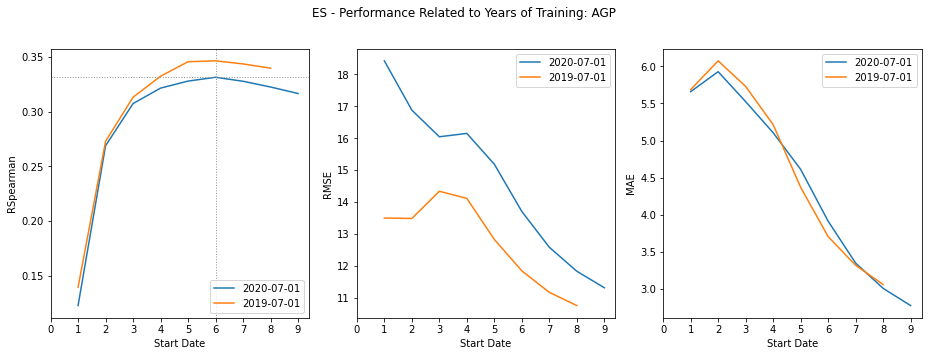

In [5]:
import matplotlib.pyplot as plt

predict_2020 = results_df[results_df.end_date == '2020-07-01']
predict_2019 = results_df[results_df.end_date == '2019-07-01']

fit, axes = plt.subplots(1, 3, figsize=(13,5))
plt.subplots_adjust(top=0.95)

ax=axes[0]
predict_2020.plot(y='mval_rspearman', x='years_training', label='2020-07-01', ax=ax)
predict_2019.plot(y='mval_rspearman', x='years_training', label='2019-07-01', ax=ax)
rspear_max = predict_2020.mval_rspearman.max()
ax.axhline(y=rspear_max, linestyle='dotted', color='xkcd:gray', linewidth=1)
rspear_max_x = predict_2020[predict_2020.mval_rspearman==rspear_max].years_training.min()
ax.axvline(x=rspear_max_x, linestyle='dotted', color='xkcd:gray', linewidth=1)
ax.set_xticks(range(10))
ax.set_ylabel('RSpearman')
ax.set_xlabel('Start Date')

ax = axes[1]
predict_2020.plot(y='mval_rmse', x='years_training', label='2020-07-01', ax=ax)
predict_2019.plot(y='mval_rmse', x='years_training', label='2019-07-01', ax=ax)
ax.set_xticks(range(10))
ax.set_ylabel('RMSE')
ax.set_xlabel('Start Date')

ax = axes[2]
predict_2020.plot(y='mval_mae', x='years_training', label='2020-07-01', ax=ax)
predict_2019.plot(y='mval_mae', x='years_training', label='2019-07-01', ax=ax)
ax.set_xticks(range(10))
ax.set_ylabel('MAE')
ax.set_xlabel('Start Date')

plt.suptitle(f'{country} - Performance Related to Years of Training: AGP', y=.98)
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.savefig(os.path.join('..', 'docs', 'source', f'years_training_agp_{country}.png'))
plt.show()


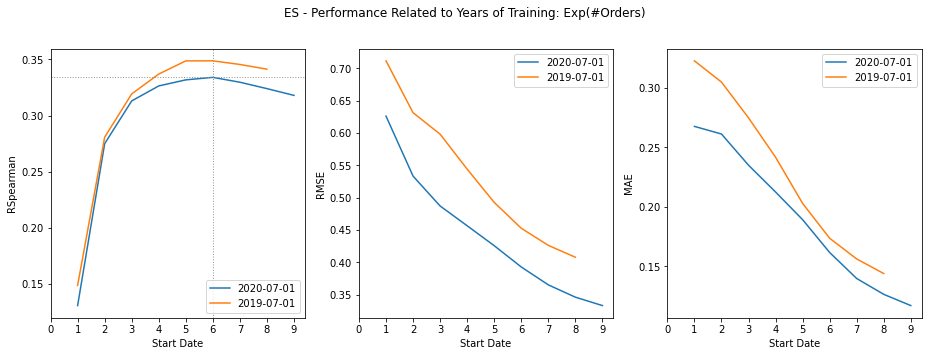

In [6]:
fit, axes = plt.subplots(1, 3, figsize=(13,5))
plt.subplots_adjust(top=0.95)

ax=axes[0]
predict_2020.plot(y='numorder_rspearman', x='years_training', label='2020-07-01', ax=ax)
predict_2019.plot(y='numorder_rspearman', x='years_training', label='2019-07-01', ax=ax)
rspear_max = predict_2020.numorder_rspearman.max()
ax.axhline(y=rspear_max, linestyle='dotted', color='xkcd:gray', linewidth=1)
rspear_max_x = predict_2020[predict_2020.numorder_rspearman==rspear_max].years_training.min()
ax.axvline(x=rspear_max_x, linestyle='dotted', color='xkcd:gray', linewidth=1)
ax.set_xticks(range(10))
ax.set_ylabel('RSpearman')
ax.set_xlabel('Start Date')

ax = axes[1]
predict_2020.plot(y='numorder_rmse', x='years_training', label='2020-07-01', ax=ax)
predict_2019.plot(y='numorder_rmse', x='years_training', label='2019-07-01', ax=ax)
ax.set_xticks(range(10))
ax.set_ylabel('RMSE')
ax.set_xlabel('Start Date')

ax = axes[2]
predict_2020.plot(y='numorder_mae', x='years_training', label='2020-07-01', ax=ax)
predict_2019.plot(y='numorder_mae', x='years_training', label='2019-07-01', ax=ax)
ax.set_xticks(range(10))
ax.set_ylabel('MAE')
ax.set_xlabel('Start Date')

plt.suptitle(f'{country} - Performance Related to Years of Training: Exp(#Orders)', y=.98)
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.savefig(os.path.join('..', 'docs', 'source', f'years_training_exporders_{country}.png'))

plt.show()


In [7]:
predict_2020['Years Training'] = predict_2020.years_training.astype('str')
parameter_df = predict_2020[['Years Training', 'g-p', 'g-q', 'g-v']].copy()
plot_title = f'{country} - Gamma-Gamma Stability Across Training Durations'
plot_filename = f'years_training_gamma_stability_2020_{country}.png'
VPLifetimesHoldoutPlots.plot_parameter_stability_pairplot(parameter_df,
                                                          'Years Training',
                                                          plot_title,
                                                          save_filename=os.path.join('..', 'docs', 'source', plot_filename))


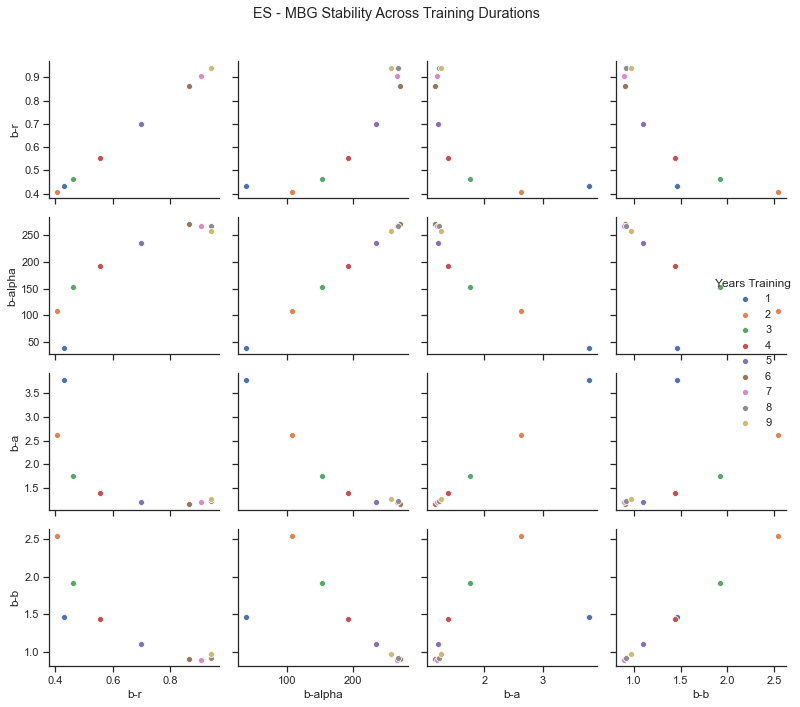

In [8]:
parameter_df = predict_2020[['Years Training', 'b-r', 'b-alpha', 'b-a', 'b-b']].copy()
plot_title = f'{country} - MBG Stability Across Training Durations'
plot_filename = f'years_training_mbg_stability_2020_{country}.png'
VPLifetimesHoldoutPlots.plot_parameter_stability_pairplot(parameter_df,
                                                          'Years Training',
                                                          plot_title,
                                                          save_filename=os.path.join('..', 'docs', 'source', plot_filename))
